In [1]:
import re
import string
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn import metrics
from dataclasses import dataclass
from typing import Any
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from pymorphy2 import MorphAnalyzer

import warnings
warnings.filterwarnings("ignore")

    В исходном файле с расширением xlsm была проблема с кодировкой и он плохо считывался. Сделал онлайн конвертацию в utf-8

In [2]:
import chardet

with open('data/train.xlsm', 'rb') as rawdata:
    result = chardet.detect(rawdata.read(100000))
result

{'encoding': None, 'confidence': 0.0, 'language': None}

In [3]:
df = pd.read_csv('data/train.csv', sep=';', encoding='utf-8')

In [4]:
df = df[['ucid', 'text_employer', 'date', 'ACTION_ITEM_RESULT_PRODUCT_NAME']]
df.head()

,ucid,text_employer,date,ACTION_ITEM_RESULT_PRODUCT_NAME
0,5.010388e+17,добрый_день. это ваш персональный_менеджер_сбе...,2021-02-26,Бизнес-карта
1,5.010389e+17,добрый_день строки. это клиентский_менеджер_сб...,2021-02-20,Зарплатные проекты
2,5.010397e+17,здравствуйте. это ваши персональный_менеджер и...,2021-02-18,Зарплатные проекты
3,5.010401e+17,добрый_день. персональный_менеджер сбер бизнес...,2021-02-24,Зарплатные проекты
4,5.010405e+17,в истории смотреть. добрый_день. менеджер_сбер...,2021-02-20,Зарплатные проекты


    В первом задании нужно по тексту предсказывать метку темы
    Отсюда делаем вывод, что другие столбцы не используем: чисто теоретически вы могли переименовать важные столбцы/фичи в unnamed, которые появляются при сохранении файла. Также можно представить ситуацию, что некоторые темы появились в определенный период времени и это может помочь с предсказанием. Например, до какой-то даты была только одна услуга. Но пока что сосредоточимся только на тексте.

    Что было обнаружено по тексту? 
    Болтовня перед моментом, когда клиент ответил на телефон (общение с колегой); матерные слова; иностранные слова; имена, названия городов, которые не влияют на тему; проблемы с транскрибацией диалогов (опечатки, неверные слова); приветствие, прощание, представляется человек, говорит свою должность и название банка (кажется данная информация не влияет на тематику продукта); цифры, знаки препинания (нужно сделать различный препроцессинг); короткие диалоги (например только приветствие), при этом у них разные классы, скорее всего есть ошибки в разметке по темам, чаще всего именно в коротких диалогах типа приветствия. Поэтому кажется что нужно оставить только длинные диалоги, в коротких больше всего мусора; дисбаланс тематик присутствует

In [5]:
# проверим на пропущенные значения, они отсутствуют
df.isna().sum()

ucid                               0
text_employer                      0
date                               0
ACTION_ITEM_RESULT_PRODUCT_NAME    0
dtype: int64

In [6]:
# темам присудим id
df['category_id'] = pd.factorize(df['ACTION_ITEM_RESULT_PRODUCT_NAME'])[0]

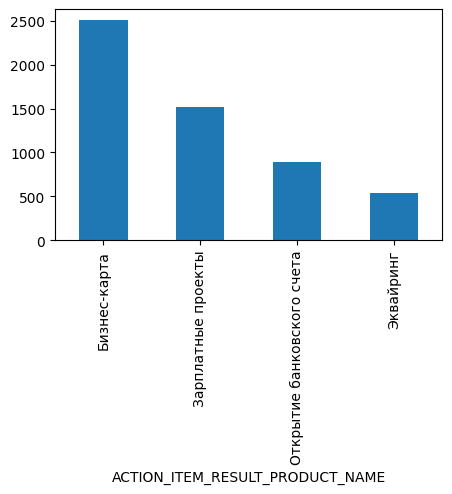

In [7]:
fig = plt.figure(figsize=(5,3))
df.groupby('ACTION_ITEM_RESULT_PRODUCT_NAME').text_employer.count().plot.bar(ylim=0)
plt.show()

    Вообще хотел глянуть на дубликаты и их классы, но было обнаружено, что помимо дубликатов присутствуют примеры, которые не несут какого-то смысла в разрезе текущей задачи классификации. Например, просто фразы приветствия и все. Также болтовня, пока клиент не ответил на звонок. Иногда сотрудник преставляется кто он и зачем звонит и все (скорее всего человек просто сбрасывает звонок). При этом данные диалоги размечены на темы. Возможно, сотрудники в базе куда-то пишут зачем они звонят и поэтому присутствуют разговоры с "болтовней". Для данной задачи такие диалоги плохо влияют, они скорее всего короткой длины и их можно фильтрануть. 

In [8]:
df['text_employer'].value_counts(dropna=False).head(5)

text_employer
добрый_день                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                50
здравствуйте                                                                                                                                                                                                                                

In [9]:
df[df['text_employer'] == 'добрый_день'].head(5)

,ucid,text_employer,date,ACTION_ITEM_RESULT_PRODUCT_NAME,category_id
84,5.010933e+17,добрый_день,2021-02-15,Зарплатные проекты,1
132,5.011273e+17,добрый_день,2021-02-24,Эквайринг,2
214,5.010174e+17,добрый_день,2021-02-20,Зарплатные проекты,1
235,5.010304e+17,добрый_день,2021-02-18,Зарплатные проекты,1
289,5.010693e+17,добрый_день,2021-02-19,Эквайринг,2


In [10]:
df[df['text_employer'].str.len() <= 50].head(5)

,ucid,text_employer,date,ACTION_ITEM_RESULT_PRODUCT_NAME,category_id
16,5.010479e+17,у меня один один,2021-02-15,Зарплатные проекты,1
42,5.010656e+17,добрый_день виктория. а это сбербанк персональный,2021-02-19,Зарплатные проекты,1
61,5.010759e+17,давай,2021-02-17,Бизнес-карта,0
84,5.010933e+17,добрый_день,2021-02-15,Зарплатные проекты,1
132,5.011273e+17,добрый_день,2021-02-24,Эквайринг,2


    Написал функцию, которая просто будет тренировать несколько классических алгоритмов и выводить результаты по ним.

In [11]:
@dataclass
class Model:
    name: str
    model: Any
    acc: float
        

def train_models(df_train, df_test):
    result = []
    models = {'NB': MultinomialNB(), 
              'SGDClassifier': 
              SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, random_state=42, max_iter=5, tol=None), 
              'RF': RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
              'LinearSVC': LinearSVC(),
              'LogisticRegression': LogisticRegression(random_state=0)
             }
    
    for name, model in models.items():
        text_clf = Pipeline([
            ('vect', CountVectorizer()),
            ('tfidf', TfidfTransformer()),
            ('clf', model),
        ])

        text_clf.fit(df_train.text_employer, df_train.category_id)
        Pipeline(...)

        predicted = text_clf.predict(df_test.text_employer)
        accuracy = np.mean(predicted == df_test.category_id)

        print(f'{name}={accuracy}')
        result.append(Model(name, text_clf, accuracy))
        
        result.sort(key=lambda x: x.acc, reverse=True)
    return result

    Функция для обработки данных: удаление стоп-слов (при этом я дополняю новыми словами этот список), фильтрую короткие диалоги, удаляю знаки препинания и цифры, приводим к нижнему регистру, делаю лемматизацию.

In [12]:
morph = MorphAnalyzer()

def data_preprocessing(df, production=False):
    stop_words = set(stopwords.words('russian'))
    stop_words = add_stop_words(stop_words)

    if production is False:
        df = filter_simple_phrases(df)
        df = filter_short_phrases(df)

    string.punctuation = string.punctuation.replace('-', '')
    df['text_employer'] = df['text_employer'].apply(lambda t: t.lower())
    df['text_employer'] = df['text_employer'].apply(replace_symbol)
    df['text_employer'] = df['text_employer'].apply(lambda x: remove_stopwords(x, stop_words))
    df['text_employer'] = df['text_employer'].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', x))
    df['text_employer'] = df['text_employer'].apply(lambda x: re.sub('\w*\d\w*', '', x))
    df['text_employer'] = df['text_employer'].apply(lemmatize)
    df = df.drop_duplicates(subset=['text_employer'])
    
    return df


def add_stop_words(stop_words):
    # seems that for classification task need to add stop words like 'hello'
    new_words = ['э', 'а', 'м', 'к', 'же', 'у', 'box', 'санкт-петербург', 'москва', 'это', 'лопух', 'вот', 'там', 'психоз', 'ну',
    'этот', 'уже', 'сантиметров', 'жесткая', 'она', 'прям', 'вообще', 'пошел', 'звоним', 'штоб', 'бога', 'на', 'максим',
    'или', 'мастер', 'кого', 'ой', 'по', 'выходной', 'давай', 'пизда', 'истории', 'пари', 'виктория', 'ma', 'ager', 'июль',
                'возможно', 'тот', 'например', 'какой-либо', 'какой-то', 'по-моему', 'когда-то', 'суббота', 'вера', 'март',
                 'gear', 'московский', 'новосибирск', 'район', 'календарь', 'турция', 'город', 'маэстро', 'как-нибудь', 'либо',
                'примерно', 'который']
    
    stop_this_task = ['добрый', 'день', 'ваш', 'менеджер', 'персональный', 'клиентский', 'спасибо', 'пожалуйста', 'свидания', 
                      'свидание', 'вопрос', 'перезвонить', 'мочь', 'рассказать', 'абсолютно', 'сбер', 'сбербанк',
       'сказать', 'уточнить', 'прощение', 'блок', 'побеспокоить', 'гугл', 'браузер', 'яндекс', 'сайт',
        'рада', 'помочь', 'вечер', 'утро', 'уделить', 'время', 'хотеть', 'также', 'удобно', 'благодарить', 'любезный', 'неделя', 
           'месяц', 'пятница', 'понедельник', 'вторник', 'среда', 'четверг', 'воскресенье', 'завтра', 'прощение']
    new_words += stop_this_task
    return set(list(stop_words) + new_words)


def filter_simple_phrases(df):
    return df[(df['text_employer'] != 'добрый_день') & (df['text_employer'] != 'здравствуйте')
              & (df['text_employer'] != 'добрый_день. добрый_день')
              & (df['text_employer'] != 'хорошо')
              & (df['text_employer'] != 'добрый')
              & (df['text_employer'] != 'а')]


def filter_short_phrases(df):
    return df[(df['text_employer'].str.len() > 100)]


def replace_symbol(x):
    return x.replace('_', ' ')


def remove_stopwords(doc, stop_words):
    filtered_doc = [token for token in word_tokenize(doc) if not token in stop_words]
    return " ".join(filtered_doc)


def lemmatize(doc):
    tokens = [morph.normal_forms(token)[0] for token in word_tokenize(doc)]
    return " ".join(tokens)

In [13]:
df_train, df_test = train_test_split(df, test_size=0.2)

In [14]:
# before text preprocessing:
models = train_models(df_train, df_test)

NB=0.6018348623853211
SGDClassifier=0.7660550458715596
RF=0.5477064220183486
LinearSVC=0.7568807339449541
LogisticRegression=0.7678899082568807


    SGDClassifier. Есть два лучших результата. Посмотрим на метрики для них. 

In [15]:
text_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier(loss='hinge', penalty='l2',
        alpha=1e-3, random_state=42,
        max_iter=5, tol=None)),
])

text_clf.fit(df_train.text_employer, df_train.category_id)
Pipeline(...)

Pipeline(steps=Ellipsis)

In [16]:
predicted = text_clf.predict(df_test.text_employer)
np.mean(predicted == df_test.category_id)

0.7660550458715596

In [17]:
print(metrics.classification_report(df_test.category_id, predicted))

              precision    recall  f1-score   support

           0       0.75      0.91      0.82       498
           1       0.80      0.66      0.72       295
           2       0.88      0.73      0.80       112
           3       0.73      0.57      0.64       185

    accuracy                           0.77      1090
   macro avg       0.79      0.72      0.75      1090
weighted avg       0.77      0.77      0.76      1090



    recall - Вероятность того, что мы скажем про этот объект что он принадлежит классу 1 при условии, что он действительно принадлежит классу 1

    precision - Вероятность того, что объект принадлежит классу 1 при условии, что наш алгоритм сказал про этот объект, что он принадлежит классу 1

    Для разных задач оптимизируют разные метрики. Например, для предсказания болезней лучше оптимизировать recall. 
    Если высокий recall, то это не значит что если мы сказали что человек болен - он действительно болен (за это отвечает precision).
    Это означает, что если человек болен на самом деле, то вы скорее всего скажите что он болен. 
    Потому что важно выцепить всех больных. 
    
    Иногда из постановки задачи понятно, какую из метрик желательнее оптимизировать. Можно также построить AUC кривую по ним, строится по разным threshold. При это может случиться так, что на одном промежутке один алгоритм себя лучше ведет, на другом промежутке - другой алгоритм. В таких случаях можно по площади под кривой определить, какой алгоритм в среднем лучше.

In [18]:
metrics.confusion_matrix(df_test.category_id, predicted)

array([[451,  25,   4,  18],
       [ 78, 196,   3,  18],
       [ 24,   2,  82,   4],
       [ 52,  23,   4, 106]])

    Бизнес-карта (0 класс). По confusion matrix можно сказать, что 1, 2, 3 класс чаще ошибаются в пользу 0го класса. Это наиболее частые ошибки. В целом в датасете присутствует дисбаланс в пользу 0го класса. Можно попробовать уровнять их. Также, есть гипотеза, что слова (добрый день, здравствуйте, меня зовут, до свидания, ваш менеджер и т.п.) присутствуют во многих фразах/классах. Хочу их добавить в стоп-слова и фильтрануть. Данные слова не несут какой-либо пользы в контексте данной задачи. UPD: да, действительно, фильтрация таких слов на 1-2% повышают accuracy.
    В целом кажется, что для начала нужно сделать упор именно на изучение диалогов. Скорее всего есть пересечения общих слов или с одним клиентом могут обсуждать несколько тематик. 
    Также 0ой класс чуть чаще ошибается в пользу 1го, чем 2го или 3го. 

In [19]:
# data preprocessing
df_filtered = df.copy()
df_filtered = data_preprocessing(df_filtered)

In [20]:
df_filtered_train, df_filtered_test = train_test_split(df_filtered, test_size=0.2)

In [21]:
# before text preprocessing:
models = train_models(df_train, df_test)

NB=0.6018348623853211
SGDClassifier=0.7660550458715596
RF=0.5477064220183486
LinearSVC=0.7568807339449541
LogisticRegression=0.7678899082568807


In [22]:
# after text preprocessing:
models = train_models(df_filtered_train, df_filtered_test)

NB=0.6747104247104247
SGDClassifier=0.7847490347490348
RF=0.6158301158301158
LinearSVC=0.7596525096525096
LogisticRegression=0.7731660231660231


    Можно увидеть, что препроцессинг данных улучшил качество всех моделей на +-0.02. Больший эффект на RF. Результат в разных экспериментах (если перзапускать notebook, данные разобьются по-другому) отличается в диапазоне 76-80%. 

    Подбор лучший параметров для модели, которая показала себя лучше остальных

In [36]:
#SGD
parameters = {
    'vect__ngram_range': [(1, 1), (1, 2)],
    'tfidf__use_idf': (True, False),
    'clf__alpha': (1e-2, 1e-4),
    'clf__max_iter': (2, 10)
}

text_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier(loss='hinge', penalty='l2',
        random_state=42, tol=None)),
])

In [37]:
gs_clf = GridSearchCV(text_clf, parameters, cv=5, n_jobs=-1)
gs_clf = gs_clf.fit(df_filtered_train['text_employer'], df_filtered_train['category_id'])

In [38]:
for param_name in sorted(parameters.keys()):
    print("%s: %r" % (param_name, gs_clf.best_params_[param_name]))

clf__alpha: 0.0001
clf__max_iter: 2
tfidf__use_idf: False
vect__ngram_range: (1, 2)


In [40]:
gs_clf.best_score_

0.7788826020549848

In [71]:
# LR
text_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', LogisticRegression(random_state=0)),
])


params = [    
    {'clf__penalty' : ['l1', 'l2', 'elasticnet'], 
    'clf__solver' : ['lbfgs','newton-cg','liblinear','sag','saga'],
    'clf__max_iter' : [100, 250, 500, 1000, 2000] 
    }
]

clf = GridSearchCV(estimator = text_clf, param_grid = params, scoring = 'accuracy', cv = 5, verbose=True, n_jobs=-1)
clf_fit = clf.fit(df_filtered_train.text_employer.iloc[:700], df_filtered_train.category_id.iloc[:700])

Fitting 5 folds for each of 5 candidates, totalling 25 fits


In [ ]:
clf_fit.best_estimator_

    При параметрах, которые показывал gridSearch не всегда были лучшие результаты, странно немного. Нужно будет перепроверить этот момент.

In [25]:
# Одна из лучших моделей
text_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, random_state=42, max_iter=5, tol=None)),
])

text_clf.fit(df_filtered_train.text_employer, df_filtered_train.category_id)
Pipeline(...)

predicted = text_clf.predict(df_filtered_test.text_employer)
accuracy = np.mean(predicted == df_filtered_test.category_id)

print({accuracy})

{0.7847490347490348}


In [28]:
# Сохраним ее
filename = "data/sgd.joblib"
joblib.dump(text_clf, filename)

['data/sgd.joblib']

    По поводу предсказаний. Уже упоминал, что встречаются текста, где только приветствие или небольшие фразы, не особо имеющие смысл. При этом в датасете для них указаны метки. Мне кажется это не корректно, потому что по данным фразам сложно определить тематику текста. 
    Что я сделал? 
    Делаем препроцессинг данных, отфильтровываем короткие фразы и на них не обучаемся. 
    Во время предсказаний я просто добавил еще одну метку, которая означала бы, что текст короткий (другая). После препроцессинга новых данных, я делаю предсказание для всех данных, но дополнительно проверяю длину текста. Если он короткий, я говорю, что данный текст слишком короткий для предсказания. Скорее всего в нем нет содержательного диалога.

In [29]:
def to_predict(df):
    field_text = 'ACTION_ITEM_RESULT_PRODUCT_NAME'
    labels = {0: 'Бизнес-карта', 1: 'Зарплатные проекты', 2: 'Эквайринг', 3: 'Открытие банковского счета',
             4: 'Болтовня'}
    
    df = df[['text_employer']]
    df['label_name'] = ''
    df['label_id'] = 4
    df['len_text'] = 0
    
    filename = "data/lr.joblib"
    model = joblib.load(filename)
    
    predicted = model.predict(df.text_employer)
    
    i = 0
    for index, row in df.iterrows():
        if len(row['text_employer']) >= 50:
            df.at[index, 'label_id'] = predicted[i] 
        df.at[index, 'label_name'] = labels[df.at[index, 'label_id']]
        df.at[index, 'len_text'] = len(row['text_employer'])
        i += 1
        
    return df

        Делаем предсказание для новых данных. Подставьте свой файл. Ниже скриншот из обучающего просто для примера (но так делать нельзя)

In [40]:
df_prod = pd.read_csv('your_file.csv', sep=';', encoding='utf-8')

In [43]:
df_prod = data_preprocessing(df_prod, production=True)

In [104]:
df_predictions = to_predict(df_prod)
df_predictions.head(10)

,text_employer,category_id,label_name,label_id,len_text
0,бизнес звонить индивидуальный предприниматель ...,0,Бизнес-карта,0,54
1,строка бизнес звонить индивидуальный предприни...,1,Зарплатные проекты,1,570
2,здравствуйте ваш бизнес звонить индивидуальный...,1,Зарплатные проекты,1,1239
3,бизнес обращаться организация бизнес стиль гов...,1,Зарплатные проекты,1,1061
4,смотреть звонить индивидуальный предпринимател...,1,Бизнес-карта,0,129
5,бизнес звонить индивидуальный предприниматель ...,0,Бизнес-карта,0,1259
6,надежда бизнес немой индивидуальный предприним...,2,Эквайринг,2,805
7,бизнес предприниматель звонить разговаривать р...,0,Бизнес-карта,0,484
8,звать бизнес звонить индивидуальный предприним...,3,Открытие банковского счета,3,1889
9,мочь обращаться бухгалтер большой перезвонить,0,Другая,4,45


    Примерно как выглядит результат функции, она возвращает df. Для теста я использовал тот же самый датасет. Так делать неправильно, просто для теста.
    Оставил оригинальные category_id, предсказанные label_id, длину текста len_text

<img src='data/predictions.png' width=960, heigth=720>

    Кроме классических ML алгоритмов, попробовал трансформер (Bert), мультиязычный, 'bert-base-multilingual-cased'. Главной сложность работы с ним было то, что не хватало мощностей, чтобы провести больше тестов с ним. Сделал несколько тестов. 

    Первый тест. Использовал для обучения только 1000 текстов из ~4300. Без препроцессинга данных. Тренировка одной эпохи занимало 50-60 минут. После 5и эпох показывал точность порядка 70%. Датасет бил на 80/10/10. Во премя обучения на валидационном смотрел результаты, после обучения на тестовом считал accuracy. Обучался на 1000 из 80% части.

<img src='data/bert_1k_5E.png' width=640, heigth=480>

    Второй тест. То же самое, но 2500 текстов. accuracy = 76%.

<img src='data/bert_2500_5E.png' width=640, heigth=480>

    Третий тест. Попробовал заморозить веса и обучать только перцептрон (последний слой), который предсказывает классы. По времени он стал тренироваться быстрее на 45 минут для размера 2500 текстов. Обучал на 3200 текстов, но стало заметно, что обучается хуже.
    Здесь использовал препроцессинг. 

<img src='data/bert_freeze.png' width=640, heigth=480>

    Веса занимают порядка 750мб, при необходимости могу залить куда-нибудь. 

    В целом, если обучать на всем датасете и пытаться оптимизировать, улучшать, то должен набирать 80-85%.

    На самом деле думал еще попробовать потестировать rubert-tiny2. Вроде хвалят для работы с русским языком. 
https://huggingface.co/cointegrated/rubert-tiny2

    Выводы:

- по поводу обучающих данных. Немного поизучал текста. Иногда в них присутствет просто болтовня операторов (момент пока клиент не ответил на звонок); проблемы с транскрибацией диалогов (опечатки, неверные слова); имена, названия городов, которые не влияют на тему и я их старался отфильтровывать; приветствие, прощание, представляется человек, говорит свою должность и название банка (кажется данная информация не влияет на тематику продукта); 
    Вообщем я постарался увеличить список стоп-слов, для решения данных проблем. Для данной задачи слова (добрый день, до свидания и т.д.) не несут большого смысла, но при этом для второй задачи они важны. Поэтому список стоп-слов отличается. (но в целом думаю я еще много чего не заметил в диалогах).
    Короткие диалоги тоже часто не содержат ничего интересного, но при этом они содержат метки. Хотя зачастую определить тематику разговора по ним кажется невозможным ('добрый день меня зовут ... я менеджер банка').
    
- Что делал? Изучал данные. Сделал препроцессинг данных (отфильтровал короткие фразы, удалил знаки прпинания, поправил фразы типа добрый_день, сделал лемматизацию, удалял стоп-слова). Идея с увеличением списка стоп-слов дает результат (многие фразы типа приветствия и болтовни не несут смысла для данной задачи), в этом направлении есть куда улучшать еще. 
    Попробовал несколько моделек классического ML (лучше всего показала LR). Попробовал Bert. Чтобы сильно улучшать результаты стоит копать в сторону DL и стоит обратить внимание на обработку данных.
    
- По confusion matrix видно, что большая часть ошибкок встречается, когда 1ый, 2ой и 3ий класс ошибаются на 0ом классе (Бизнес-карта). Возможно, у них есть сильные пересечения по словам, может быть мало данных для некоторых классов (присутствует дисбаланс в сторону 0го класса в данных), также возможно что большие диалоги могут содержать несколько тематик. 

- accuracy в разных экспериментах принимала значения от 77% до 80% для LR. Bert лучший результат был 76%, но у меня не хватает мощностей, что дольше его тренировать и использовать все доступные данные, использовал только около половины. 

- Пробовал подбирать гиперпараметры для моделек классического ML, особо результата не дало. 

- Теоретический можно попробовать подтянуть даты для предсказаний. Может быть так, что некоторые тематики не присутствовали до определенной даты.

- Можно еще порыться в ucid поле. Но я в основном изучал текста. 